# Coronavirus Reverse Engineering

Reverse engineering of the Coronavirus, in particular of SARS-CoV-2 which is the responsible of the current pandemic. We'll analyze the genome of samples available online to understand what this virus does.

**TABLE OF CONTENTS**

1. [Fetch data (from NCBI)](#section1)
2. [Exploratory data analysis](#section2)
3. [Genome sequence analysis](#section3)

**Disclaimer**: this notebook is still under construction.

In [1]:
from matplotlib import pyplot as plt

from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image

from sklearn.linear_model import LinearRegression

from reportlab.lib import colors
from reportlab.lib.units import cm

from Bio import Seq
from Bio import Entrez
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3

import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib

from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import os
import lzma as xz

# data folders
root_folder = "./data/genbank/"
viruses = ["coronaviridae"]

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 

hidden_columns = ["sequence", "file_path"]
hidden_cds_columns = ["translation", "file_path", "location"]

max_unknown_nucleotides = 10

# 1. Fetch data (from NCBI) <a id="section1"></a>

Fetch the latest data from NCBI using keywords and a genome size range. 

In [2]:
base_folder = "./data/genbank/"

Entrez.email = 'coronaversing@gmail.com'
size_and_date = "(\"28000\"[SLEN] : \"35000\"[SLEN]) AND (\"2019/12/01\"[PDAT] : \"2020/12/31\"[PDAT])"
genbank_search_query = {"coronaviridae": ["SARS-CoV-2[All Fields] AND " + size_and_date,
                                          "2019-nCoV[All Fields] AND " + size_and_date,
                                          "coronavirus[All Fields] AND " + size_and_date]}

def fetch_gb(path, gid):
    handle = Entrez.efetch(db='nucleotide', id=gid, rettype='gb')
    local_file = open(path + "/" + gid + ".gb", 'w')
    local_file.write(handle.read())
    handle.close()
    local_file.close()

genome_files = genbank_search_query
viruses = genbank_search_query.keys()
    
count = 0
for vrs in viruses:
    
    data_folder = base_folder + vrs
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    for keywords in genome_files[vrs]:
        handle = Entrez.esearch(db="nucleotide", retmax=500, term=keywords, idtype="acc")
        record = Entrez.read(handle)
        ids = record["IdList"]
        handle.close()

        for genbank_id in ids:
            file_name = data_folder + "/" + genbank_id + ".gb"
            count += 1
            if not os.path.exists(file_name):
                print("[+]  --- * fetching (", vrs, ")", file_name)
                downloaded = False
                count = 0
                while not downloaded:
                    try:
                        fetch_gb(data_folder, genbank_id)
                        downloaded = True
                    except:
                        if count == 5:
                            print("[+]  --- * couldn't get (", vrs, ")", genbank_id)
                            break
                        count += 1
                        time.sleep(3)
                        pass

print("[+] Collected", count, " gb files")

[+] Collected 436  gb files


# 2. Exploratory data analysis <a id="section2"></a>

First of all, let's take a look at the data structure and condense it on a data frame. We are only interested in complete genomes, or maybe with a high coverage of the coding region.

In [3]:
def get_genomes():
    for vrs in viruses:    
        # define data frame structure for viruses
        feature_columns = ["country", "host", "strain", "collection_date"]
        sample_columns = ["id", "length", "date", "information", "description", "sequence", "file_path"]
        total_columns = sample_columns + feature_columns
        vrs_frame = {i:list() for i in total_columns}

        # define data frame structure for CDS
        cds_feature_columns = ["protein_id", "product", "gene", "codon_start", "translation"]
        cds_sample_columns = ["oid", "type", "file_path", "location", "start", "end", "length"]
        cds_columns = cds_feature_columns + cds_sample_columns
        cds_frame = {i:list() for i in cds_columns}

        # loop over gb files
        data_folder = root_folder + vrs + "/"
        for filename in os.listdir(data_folder):
            if filename.endswith(".gb"): 
                for seq_record in SeqIO.parse(data_folder + filename, "genbank"):

                    # get genome sequence, under certain tolerance to unknown nucleotides
                    genome_sequence = seq_record.seq
                    if genome_sequence.count("N") > max_unknown_nucleotides:
                        continue
                        
                    if not (seq_record.annotations['molecule_type'] == "RNA" or seq_record.annotations['molecule_type'] == "ss-RNA"):
                        continue 
                    
                    # get several additional variables from genbank file featues (if availbale)
                    for ftrs in seq_record.features:
                        
                        # some metada of the sample
                        if ftrs.type == "source":                        
                            for var in feature_columns:                        
                                if var in ftrs.qualifiers:
                                    # sanitize country
                                    if var == "country":
                                        country = ftrs.qualifiers[var][0]
                                        country = country.split(":")[0]
                                        vrs_frame["country"].append(country.lower())
                                    # sanitize host
                                    elif var == "host":
                                        host = ftrs.qualifiers[var][0]
                                        host = host.split(";")[0]
                                        vrs_frame["host"].append(host.lower())
                                    else:
                                        vrs_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    vrs_frame[var].append("unknown")

                        # collect cds data in a different dataframe
                        if "protein_id" in ftrs.qualifiers:                        
                            for var in cds_feature_columns:                        
                                if var in ftrs.qualifiers:
                                    cds_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    cds_frame[var].append("unknown")

                            cds_frame["start"].append(ftrs.location.start)
                            cds_frame["end"].append(ftrs.location.end)
                            cds_frame["length"].append(len(ftrs.location))
                            cds_frame["location"].append(ftrs.location)
                                
                            # cds data of the record
                            cds_frame["oid"].append(seq_record.id)
                            cds_frame["file_path"].append(data_folder + filename)
                            cds_frame["type"].append(ftrs.type)

                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(seq_record.seq).encode('utf-8')))

                    # genome length
                    genome_length = len(seq_record.seq)

                    # sample (virus) data
                    vrs_frame["id"].append(seq_record.id)
                    vrs_frame["date"].append(pd.to_datetime(seq_record.annotations["date"]))
                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(seq_record.description)

            else:
                continue

        df = pd.DataFrame.from_dict(vrs_frame)
        cdf = pd.DataFrame.from_dict(cds_frame)
        return (df, cdf)

if os.path.isfile(cache_vrs_file):
    corona_orig = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
else:
    corona_orig, corona_cds = get_genomes()
    corona_orig.to_pickle(cache_vrs_file)
    corona_cds.to_pickle(cache_cds_file)

display(HTML(corona_orig.drop(hidden_columns, axis=1).head().to_html()))
display(HTML(corona_cds.drop(hidden_cds_columns, axis=1).head().to_html()))

,id,length,date,information,description,country,host,strain,collection_date
0,LC063818.1,27904,2015-11-05,1.261989,"Porcine epidemic diarrhea virus genomic RNA, complete genome, strain: KMM-2/JPN/2014",japan,sus scrofa domesticus,KMM-2/JPN/2014,2014-01
1,GU553365.1,29644,2010-02-08,1.188778,"SARS coronavirus HKU-39849 isolate TCVSP-HARROD-00003, complete genome",usa,chlorocebus aethiops,HKU-39849,05-Dec-2007
2,KX425847.1,27709,2017-03-18,1.274860,"Infectious bronchitis virus strain ck/CH/LJL/140734, complete genome",china,gallus gallus,ck/CH/LJL/140734,2014
3,LC063838.1,27481,2015-11-05,1.280082,"Porcine epidemic diarrhea virus genomic RNA, complete genome, strain: MYG-1/JPN/2014",japan,sus scrofa domesticus,MYG-1/JPN/2014,2014-07
4,KY581684.1,30123,2017-12-20,1.163873,"Middle East respiratory syndrome-related coronavirus strain Hu/UAE_002_2013, complete genome",united arab emirates,homo sapiens,Hu/UAE_002_2013,10-Jul-2013


,protein_id,product,gene,codon_start,oid,type,start,end,length
0,BAT33160.1,polyprotein,ORF1ab,1,LC063818.1,CDS,234,20579,20346
1,BAT33161.1,spike protein,S,1,LC063818.1,CDS,20575,24736,4161
2,BAT33162.1,hypothetical protein,ORF3,1,LC063818.1,CDS,24735,25410,675
3,BAT33163.1,envelope protein,E,1,LC063818.1,CDS,25390,25621,231
4,BAT33164.1,membrane protein,M,1,LC063818.1,CDS,25628,26309,681


## 2.1. Genome size 

Let's look at the genome size and also the information distribution among all samples. The information column it's defined as the inverse of the amount of bytes of the genome compressed using lzma. It should be an indicator of the amount of information encoded in the sequence. A higher compression indicates a more ordered state (low entropy) which is equivalent to a high amount of information (think of a completely random sequence of base pairs, the comprression ratio will be pretty high, since it doesn't have much information on it)

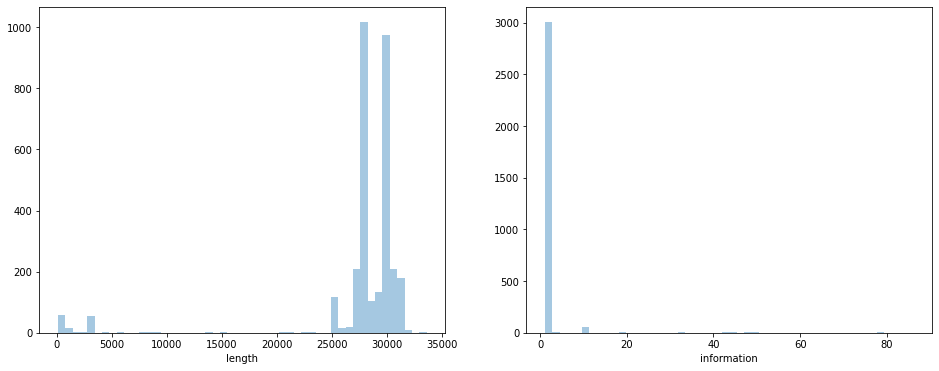

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_orig["length"], kde=False, ax=axs[0]);
sns.distplot(corona_orig["information"], kde=False, ax=axs[1]);

There are a few outliers in the dataset, some genomes are less than ~25k base pairs and some higher than ~32k which is known to be the size range of coronaviruses genomes; most likely some are incomplete sequences. Let's take a closer look to this outliers and plot the genome size distribution.

In [5]:
mean = corona_orig["length"].mean()
std = corona_orig["length"].std()

md("$\overline{x} = %.2f$ *bps*"%mean)

$\overline{x} = 27641.33$ *bps*

In [6]:
md("${s} = %.2f$ *bps*"%std)

${s} = 5781.19$ *bps*

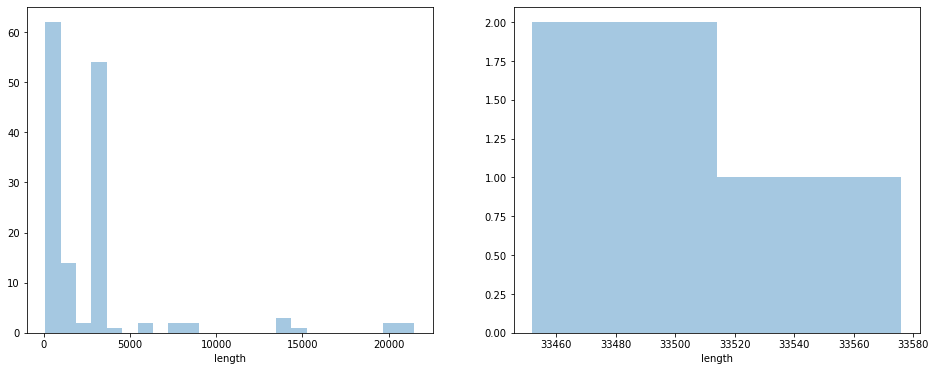

In [7]:
# let's use 1 std to detect outliers
cutoff_left = mean - std
cutoff_right = mean + std

outliers_low = corona_orig[corona_orig["length"] < cutoff_left]
outliers_high = corona_orig[corona_orig["length"] > cutoff_right]
    
if(len(outliers_high) > 0):
    fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
    sns.distplot(outliers_high["length"], kde=False, ax=axs[1]);
    sns.distplot(outliers_low["length"], kde=False, ax=axs[0]);
else:
    plt.figure(figsize=(16, 6))
    sns.distplot(outliers_low["length"], kde=False);

There seems to be some anomalies for cases with a genome below ~16k. Let's look at this cases more closely.

In [8]:
bps_low_limit = 16000
outliers_low_values = outliers_low[outliers_low["length"] < bps_low_limit]
display(HTML(outliers_low_values.head(10).drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
5,MT186680.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/257182/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",iran,homo sapiens,unknown,17-Feb-2020
22,MT081068.1,1260,2020-02-20,18.796992,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/HS_194/human/2020/CHN nucleocapsid phosphoprotein (N) gene, complete cds",china,homo sapiens,unknown,06-Feb-2020
26,KF294433.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-127 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus sinicus,unknown,2012
41,KF294439.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-29 RNA-dependent RNA polymerase gene, partial cds",china,miniopterus schreibersii,unknown,2012
95,KF294440.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-97 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus sinicus,unknown,2012
112,KF294382.1,13631,2020-03-16,2.512563,"Anlong Ms bat coronavirus isolate Neixiang-32 orf1ab polyprotein gene, partial cds",china,myotis davidii,unknown,2012
116,KF294427.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-106 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus monoceros,unknown,2012
136,KF294436.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-132 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus monoceros,unknown,2012
141,KF294376.1,2780,2020-03-16,10.040161,"Lushi Ml bat coronavirus isolate Neixiang-27 RNA-dependent RNA polymerase gene, partial cds",china,murina leucogaster,unknown,2012
156,MT186676.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/1337/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",iran,homo sapiens,unknown,03-Mar-2020


We can grab the top keywrods used in the description of this submissions.

In [9]:
def top_keywords(df):
    descrps = []
    for descrp in df["description"]:
        descrps.append(descrp)
    
    stopwords = ['the','about','an','and','are','at','be','can','for','from','if','in','is','it','of','on','or','that','this','to','you','your','with',]
    tfidf = TfidfVectorizer(max_features=10, stop_words=stopwords)
    tfidf.fit_transform(descrps)
    response = tfidf.transform(descrps)

    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

    top_keyworkds = feature_array[tfidf_sorting][:5]

    display(HTML(pd.DataFrame(top_keyworkds, columns=["keywords"]).to_html()))

top_keywords(outliers_low_values)

,keywords
0,rna
1,partial
2,gene
3,isolate
4,coronavirus


These sequences are partial genomes or isolated genes, we can safely ignore this by setting a genome size cutoff at 16k. 

In [10]:
corona = corona_orig[corona_orig["length"] > bps_low_limit]

Additionally, let's explore the keywords in the description of the remaining submissions.

In [11]:
top_keywords(corona)

,keywords
0,isolate
1,genome
2,complete
3,virus
4,syndrome


Finally let's plot the genome size and information distribution among the remaining samples.

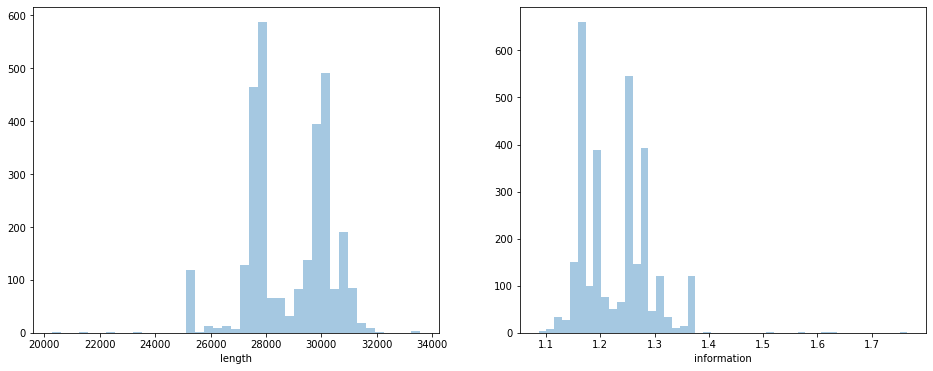

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona["length"], kde=False, ax=axs[0]);
sns.distplot(corona["information"], kde=False, ax=axs[1]);

By looking at the graphs, it seems that both the genome size and information have pretty much the same distribution. We should study the correlation between this two parameters and look for samples outside the general trend. Given the nature of viruses, one would expect that over time the amount of information is preserved regardless of the genome size. This might not be an accurate measure of that behavior, but it's useful to spot anomalies in the data.

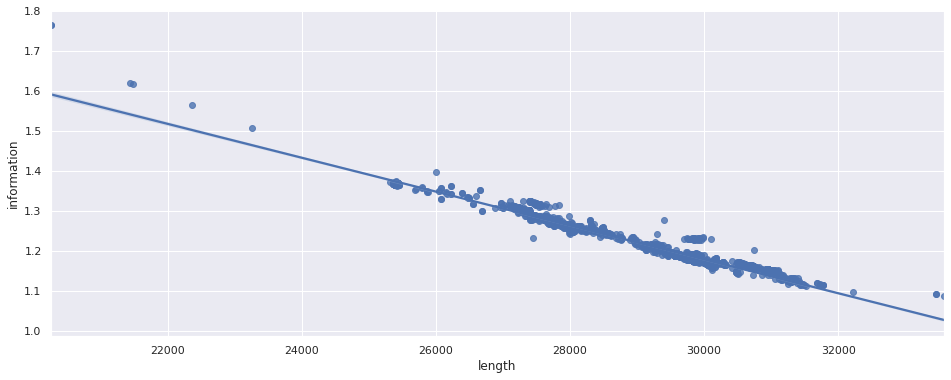

In [13]:
plt.figure(figsize=(16, 6))
sns.set(color_codes=True)
sns.regplot(x="length", y="information", data=corona[["length", "information"]]);

In [14]:
x = corona["length"].values.reshape(-1, 1)
y = corona["information"].values.reshape(-1, 1)
reg = LinearRegression().fit(x, y) 
information_outliers = (100 * (y - reg.predict(x)) / reg.predict(x)) > 5
display(HTML(corona[information_outliers].drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
114,KJ541759.1,33452,2014-08-20,1.093135,"Ball python nidovirus strain 07-53, complete genome",usa,python regius,07-53,01-Jun-2007
614,KF294456.1,21444,2020-03-16,1.621271,"SARS-related bat coronavirus isolate Jiyuan-331 orf1ab polyprotein gene, complete cds",china,rhinolophus ferrumequinum,unknown,2012
757,NC_024709.1,33452,2018-08-13,1.093135,"Ball python nidovirus strain 07-53, complete genome",usa,python regius,07-53,01-Jun-2007
1023,KM589359.1,20261,2015-04-29,1.765537,"Bovine nidovirus TCH5, complete genome",usa,bos taurus,unknown,2013
1910,NC_027199.1,20261,2018-08-13,1.765537,"Bovine nidovirus TCH5, complete genome",usa,bos taurus,unknown,2013
2226,MG600028.1,29409,2018-11-08,1.276813,"Hainan hebius popei torovirus strain LPSC33749 1ab protein, spike protein, and hypothetical protein genes, complete cds",china,hebius popei,LPSC33749,unknown
3041,MG752895.1,33576,2018-01-27,1.086484,"Ball python nidovirus 1 isolate 148, complete genome",usa,python regius,unknown,30-Nov-2016


There are a few anomalies that have information values above (5%) the fitted line, but the more interesting ones are SARS-related KF294456.1 and KF294456.1, with a (pressumably) genome size ~21k and a high amount of information. By looking at the description these are actually CDSs and not complete genomes. The increase of information could be explained by the removal of the non coding region of the genome. In any case, we'll have to take into account when comparing genomes that some samples might have only coding regions or have partial information of the genome.

In [15]:
md("In total we collected $n = %i$ samples "%(len(corona)))

In total we collected $n = 3000$ samples 

## 2.2. Genome size over time

Another interesting thing to do, it's to analyze how the genome size changed over time, specially on the samples submitted the past month.


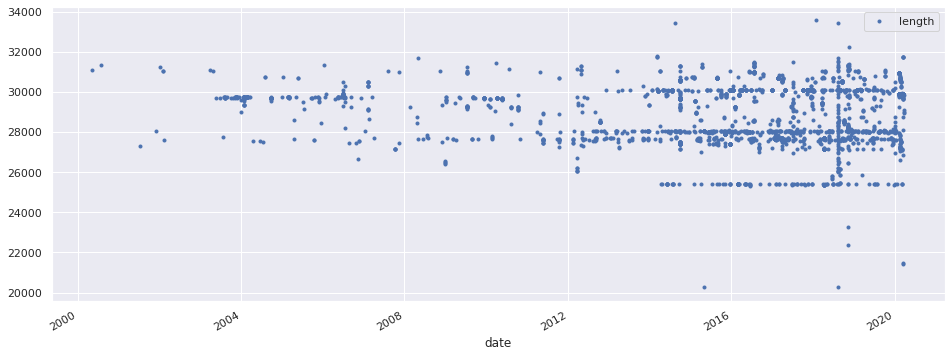

In [16]:
corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

It is clear that there is a diversity on the genome size of the submissions, which might be related that some sequences only represent coding regions and that we are dealing with various species that should be clustered for a deeper analysis per strain. A protein level analysis of the samples will be better to reveal similarities among all the genomes in the dataset. 

What about the samples submitted since december 2019?

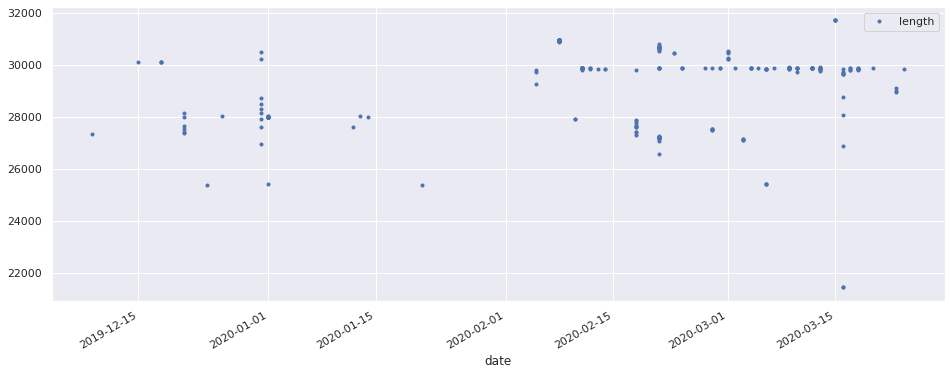

In [17]:
novel_corona = corona[corona["date"] > pd.to_datetime("2019-12-01")]
novel_corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

We know the genome size of the Wuhan virus has a size of 29903 bps. How many samples with that genome size do we have?

In [18]:
ncov = corona[corona["length"] == 29903]
display(HTML(ncov.drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
226,MT163718.1,29903,2020-03-10,1.190476,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA6-UW3/human/2020/USA, complete genome",usa,homo sapiens,unknown,29-Feb-2020
228,MT163719.1,29903,2020-03-10,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA7-UW4/human/2020/USA, complete genome",usa,homo sapiens,unknown,01-Mar-2020
499,MT135043.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/233/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020
630,MT135044.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/235/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020
954,MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
955,MT135041.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/105/human/2020/CHN, complete genome",china,homo sapiens,unknown,26-Jan-2020
1808,MT049951.1,29903,2020-02-12,1.189910,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/Yunnan-01/human/2020/CHN, complete genome",china,homo sapiens,unknown,17-Jan-2020
1864,MT039890.1,29903,2020-02-11,1.191611,"Severe acute respiratory syndrome coronavirus 2 isolate SNU01, complete genome",south korea,homo sapiens,unknown,Jan-2020
1878,NC_045512.2,29903,2020-03-13,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
2004,MT135042.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/231/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020


All of them were reported this year, consistently with what we know.

In [19]:
md("Total ncov samples $n = %i$ samples "%(len(ncov)))

Total ncov samples $n = 12$ samples 

From all these SARS-CoV-2 samples, which one we should use as a reference for a genome variation analysis? We should look at the collection date (which is different from the date in the genbank annotations) and use the ones collected in december 2019.

In [20]:
reference_corona = corona[corona["collection_date"] == "Dec-2019"]
display(HTML(reference_corona.drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
954,MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
1878,NC_045512.2,29903,2020-03-13,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019


## 2.2. Host and country distribution

What about the host and country distribution? Let's plot that for all time samples and novel samples (submissions after december 2019)

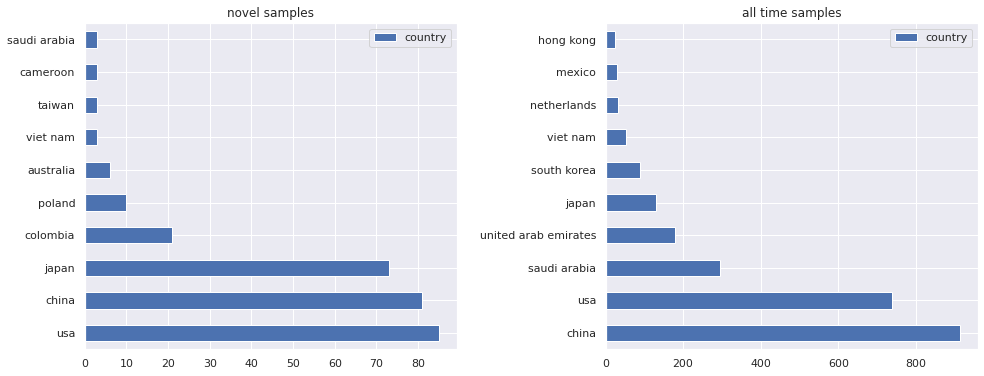

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

countries = pd.DataFrame(novel_corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

countries = pd.DataFrame(corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

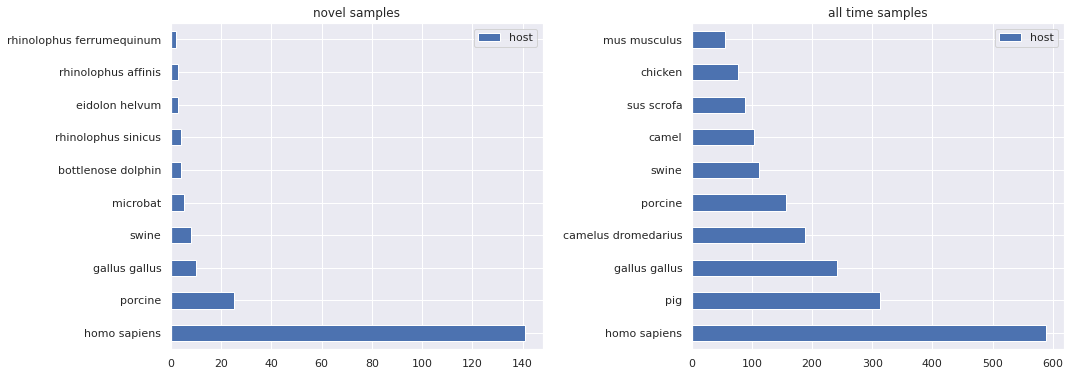

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

hosts = pd.DataFrame(novel_corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

hosts = pd.DataFrame(corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]

hosts.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

# 3. Genome sequence analysis <a id="section3"></a>

Now we have a pretty good picture of the data available. But what does this virus actually do? What does it look like? In order to have a better understanding we should analyze the coding sequences on the genome, which determines the sequence of amino acids in the protein that the virus needs to replicate.

## 3.1. Coding regions in the genome

Let's focus on a single sample to analyze the distribution of coding regions in the genome to have a better understading of the viral proteins. We'll look at the sample MN908947.3 which is the one we are going to use as a reference genome.

The features in the genbank file contains information of each protein and the translated sequence of aminoacids. Most of the time this features type are called CDS. Each one starts with a starting codo ('atg' which corresponds to Met (M) most of the time). Let's take a look at each sequence that codes for a protein and the position in the genome.

In [23]:
ncov = reference_corona[reference_corona["id"] == "MN908947.3"]
cds_ncov = corona_cds[corona_cds["oid"] == "MN908947.3"]
display(HTML(cds_ncov.drop(hidden_cds_columns, axis=1).to_html()))
display(HTML(ncov.drop(hidden_columns, axis=1).to_html()))

,protein_id,product,gene,codon_start,oid,type,start,end,length
7972,QHD43415.1,orf1ab polyprotein,orf1ab,1,MN908947.3,CDS,265,21555,21291
7973,QHD43416.1,surface glycoprotein,S,1,MN908947.3,CDS,21562,25384,3822
7974,QHD43417.1,ORF3a protein,ORF3a,1,MN908947.3,CDS,25392,26220,828
7975,QHD43418.1,envelope protein,E,1,MN908947.3,CDS,26244,26472,228
7976,QHD43419.1,membrane glycoprotein,M,1,MN908947.3,CDS,26522,27191,669
7977,QHD43420.1,ORF6 protein,ORF6,1,MN908947.3,CDS,27201,27387,186
7978,QHD43421.1,ORF7a protein,ORF7a,1,MN908947.3,CDS,27393,27759,366
7979,QHD43422.1,ORF8 protein,ORF8,1,MN908947.3,CDS,27893,28259,366
7980,QHD43423.2,nucleocapsid phosphoprotein,N,1,MN908947.3,CDS,28273,29533,1260
7981,QHI42199.1,ORF10 protein,ORF10,1,MN908947.3,CDS,29557,29674,117


,id,length,date,information,description,country,host,strain,collection_date
954,MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019


So we got 10 entries (of type CDS) that are coding sequences in the genome for polypeptides. I theory, we should get the same segments by looking at the genome sequence and extracting all nucleotides chains starting with an 'atg' codon until a STOP codon is found. 

We identify (by the name of the genes) the structural (S,E,M and N) proteins of the virus described in the literature. The virus is enclosed by a membrane that includes the S (spike) protein, which will mediate attachment and entry into cells, M (membrane) protein, which is involved in organization of the nucleoprotein inside, and E (envelope) protein, which is a membrane channel involved in budding of the virus and may be incorporated into the virion during that process. The nucleoprotein inside includes many copies of the N (nucleocapsid) protein bound to the genomic RNA.

Here there is a nice ilustration of it. EHLO virus.

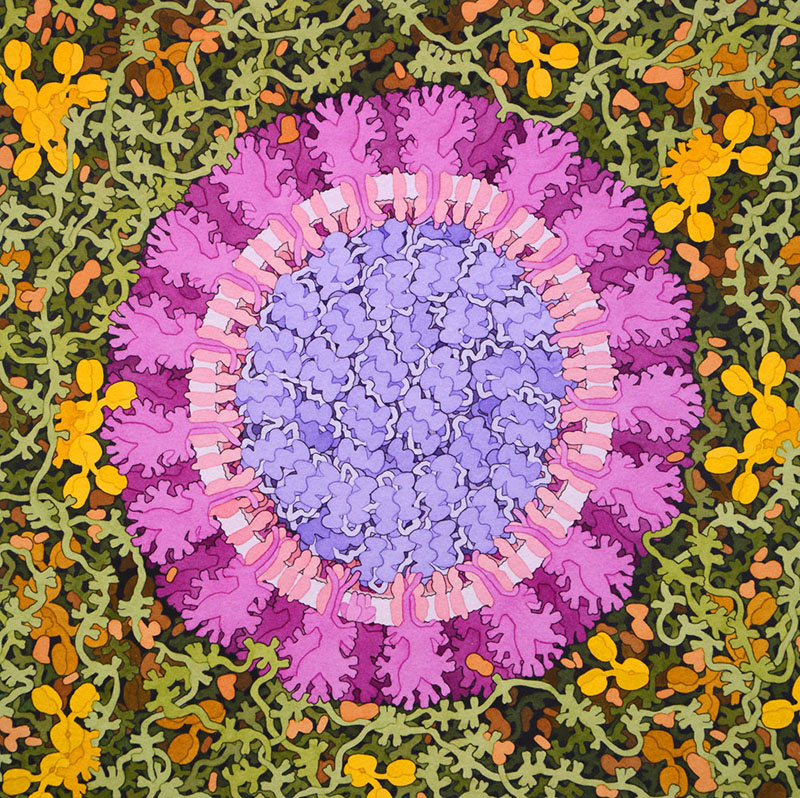

In [24]:
Image("data/images/coronavirus.jpeg")

Let's do this exercise to make sure everything is consistent. We are going to look for all possibles ORF (open reading franmes) which potentially can code a protein. Keep in mind we have to scan the genome in 3 different reading frames for start codons (ATG) until we find a stop codon. We are going to put a minimum amount of nucleotides since we kind of know the size of the proteins. 

In [25]:
# function to get ORFs
def get_orfs(sequence, frame_shift = 0, max_nt = 100):
    start_codon = "ATG"
    stop_codons = ["TAG", "TGA", "TAA"]

    # go over the genome and find all start codons
    segments = []
    start = -1
    end = -1
    inside_segment = False

    for idx in range(frame_shift, len(sequence), 3):
        codon = sequence[idx:idx+3]

        if codon == start_codon and not inside_segment:
            start = idx
            inside_segment = True

        if codon in stop_codons and inside_segment:
            end = idx + 3

        if start != -1 and end != -1:
            if (end - start) + 3 > max_nt:
                segments.append((start, end))
            start = -1
            end = -1
            inside_segment = False

    segments.sort(key=lambda tup: tup[1] - tup[0], reverse=True)  # sorts in place

    return segments    

We should get all possible ORFs in different reading frames.

In [26]:
# get the genome sequence
ncov_genome = ncov["sequence"].values[0]
orfs = []

for frame_shift in [0, 1, 2]:
    orfs += get_orfs(ncov_genome, frame_shift, 100)

print("[+] Got", len(orfs), " ORFs")

[+] Got 55  ORFs


Alright, so we got quite a lot of ORFs, much more than the amount listed on the genbank file. What could be the reason for this discrepancy? Maybe some protein sequences are not annotated in the file because are not expressed? Or could be that we are missing some underlying process that only express certain coding regions and not others?

Before anything, let's make sure we got the proteins right and our results are consistent with the annotations on the genbank file. We should check the ORFs we got are the same than the ones listed on the MN908947.3 table.

In [27]:
# let's remove rows of the dataframe when we find one of the proteins in our set of ORFs
missing_proteins = cds_ncov

for orf in orfs:
    start = orf[0]
    end = orf[1]
    length = end - start
    protein = cds_ncov[(cds_ncov["start"] == start) & (cds_ncov["length"] == length)]
    if(len(protein) > 0):
        missing_proteins = missing_proteins.drop(protein.index.values[0])

if(len(missing_proteins) > 0):
    display(HTML(missing_proteins.drop(hidden_cds_columns, axis=1).to_html()))
else:
    print("[+] All covered")

,protein_id,product,gene,codon_start,oid,type,start,end,length
7972,QHD43415.1,orf1ab polyprotein,orf1ab,1,MN908947.3,CDS,265,21555,21291
7973,QHD43416.1,surface glycoprotein,S,1,MN908947.3,CDS,21562,25384,3822


So we covered pretty much everything, except two cases. Do we have a coding segmenst of of a similar sizes or at the same starting position?

In [28]:
def find_similar_cds(protein):
    target_start = protein["start"].values[0]
    target_start_left = target_start - 0.10 * target_start
    target_start_right = target_start + 0.10 * target_start

    target_length = protein["length"].values[0]
    target_length_left = target_length - 0.10 * target_length
    target_length_right = target_length + 0.10 * target_length

    matches = []
    for orf in orfs:
        start = orf[0]
        end = orf[1]
        length = 3 + (end - start)

        if (length > target_length_left and length < target_length_right) and (start > target_start_left and start < target_start_right):
                matches.append((start, end))

        if (start == target_start):
                matches.append((start, end))
        
    return matches

So let's start analyzing the S protein (QHD43416.1) to see what's going on. 

In [29]:
s_protein = missing_proteins[missing_proteins["protein_id"] == "QHD43416.1"]
matches = find_similar_cds(s_protein)
for m in matches:
    print("[+] Found similar match", m, " of length ", m[1] - m[0])

[+] Found similar match (21535, 25384)  of length  3849


Interesting. So we found a CDS of similar size around the same starting point and exactly the same end position (STOP codon). So it seems that the initial sequence of translated peptide it's not on the final protein? At least that's what it looks like. This sounds a lot like a signal peptide which is a mechanism used for targeting proteins to different parts of the cell and are removed during cotranslational transport through the endoplasmic reticulum.

Let's extract the inital sequence of peptides to see what we are dealing with.

In [30]:
s_protein_sequence = s_protein["translation"].values[0]
odf = ncov_genome[21535:25384].translate(to_stop=True)

idx = odf.find(s_protein_sequence[:15])
cleavaged_peptide = odf[0:idx]
print(seq3(cleavaged_peptide))

MetPheLeuLeuThrThrLysArgThr


So that's the signal peptide sequence that it's pressumably removed from the S protein. It's composed of 9 aminoacids which is consistent with the difference we saw on the initial codon.

In [31]:
print("Should be zero :", 21562 - (21535 + 3*9))
print("And should be equal :", odf[idx:] == s_protein_sequence)

Should be zero : 0
And should be equal : True


And that's that. Let's take a look at the other CDS (orf1ab).

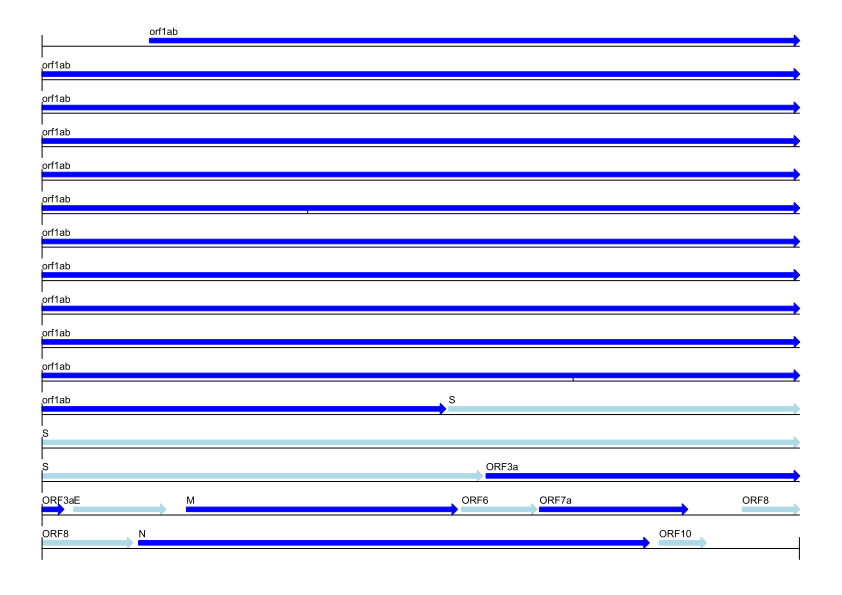

In [32]:
record = SeqIO.read(ncov["file_path"].values[0], "genbank")

gd_diagram = GenomeDiagram.Diagram(record.id)
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

for feature in record.features:
    if feature.type != "gene":
        #Exclude this feature
        continue
    if len(gd_feature_set) % 2 == 0:
        color = colors.blue
    else:
        color = colors.lightblue
    gd_feature_set.add_feature(feature, sigil="ARROW", color=color, label=True, label_size = 10, label_angle=0)

    
# #I want to include some strandless features, so for an example
# #will use EcoRI recognition sites etc.
# for site, name, color in [("GAATTC","EcoRI",colors.green),
#                           ("CCCGGG","SmaI",colors.orange),
#                           ("AAGCTT","HindIII",colors.red),
#                           ("GGATCC","BamHI",colors.purple)]:
#     index = 0
#     while True:
#         index  = record.seq.find(site, start=index)
#         if index == -1 : break
#         feature = SeqFeature(FeatureLocation(index, index+len(site)))
#         gd_feature_set.add_feature(feature, color=color, name=name,
#                                    label=True, label_size = 10,
#                                    label_color=color)
#         index += len(site)

gd_diagram.draw(format="linear", pagesize='A4', fragments=16,
                start=0, end=len(record))

gd_diagram.write("data/images/genome.png", "png")
Image("data/images/genome.png")